# Equilibrating the 17-alanine simulation

The aim of this notebook is to create an equilibrated 17-alanine simulation. 

We will do this in the following steps:
1. Load the current 17-alanine simulation from SubtleGame.
2. Run the simulation for 1.5 ns. This should ensure that the energies and temperature are stable.
3. Save the simulation with the serialized State to an XML file.

In [1]:
from nanover.omni.openmm import OpenMMSimulation
from nanover.openmm import serializer
from openmm import app
import os

## Step 1: Storing the file names

In [2]:
# 1 - input
input_xml_file = "17-ala_original.xml"

# 2 - equilibrated system
equilibrated_xml_file = "17-ala_equilibrated.xml"
equilibration_dcd_file = "17-ala_equilibration_trajectory.dcd"
equilibration_statedata_file = "17-ala_equilibration_trajectory.log"

## Step 2: Equilibration

In [ ]:
# Create server
simulation = OpenMMSimulation.from_xml_path(input_xml_file)
simulation.load()

# Create reporters for recording the simulation
dcd_reporter = app.DCDReporter(equilibration_dcd_file, 1)
statedata_reporter = app.StateDataReporter(equilibration_statedata_file, 1, 
                                           temperature=True, step=True,
                                           time=True, potentialEnergy=True, kineticEnergy=True)

# Attach reporters
simulation.simulation.reporters.append(dcd_reporter)
simulation.simulation.reporters.append(statedata_reporter)

In [ ]:
# Perform energy minimisation
simulation.simulation.minimizeEnergy()

In [ ]:
# Set parameters
total_time_in_ps = 1500
time_step_interval = 0.002 # in ps
desired_interval_in_ps = 100

total_num_steps = total_time_in_ps/time_step_interval
print(f"Running for {total_num_steps} steps")

# Run the dynamics
cumulative_total_time_ps = 0

for n in range(int(total_time_in_ps/desired_interval_in_ps)):
    
    simulation.simulation.step(desired_interval_in_ps)
    cumulative_total_time_ps += desired_interval_in_ps
    print(f"{cumulative_total_time_ps} ps run.")

    # Save the simulation with the serialized State
    file_name =  f"17-ala_equilibration_run_{cumulative_total_time_ps}_ps.xml"
    with open(file_name, 'w') as outfile:
        outfile.write(serializer.serialize_simulation(simulation.simulation, save_state=True))

with open(equilibrated_xml_file, 'w') as outfile:
        outfile.write(serializer.serialize_simulation(simulation.simulation, save_state=True))

In [ ]:
# Close the reporters
dcd_reporter.__del__()
statedata_reporter.__del__()

## Step 2.5: Analysis

Read the data saved by the StateDataReporter to plot the temperature and potential energy.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Define data labels
pot_energy_label = "Potential Energy (kJ/mole)"
temp_label = "Temperature (K)"
sim_step_label = "Step #"
sim_step_axis_label = "Simulation step"

rolling_avg_temperature ="Rolling average temperature"
rolling_stddev_temperature = "Rolling std dev temperature"
rolling_avg_potential_energy ="Rolling average potential energy"
rolling_stddev_potential_energy = "Rolling std dev potential energy"

# Load the log file into a Pandas DataFrame
df = pd.read_csv(equilibration_statedata_file, sep=",")

# Format the column headings
sim_step_label = "Step #"
df = df.rename(columns={'#"Step"': sim_step_label})

# Compute rolling averages
steps = 200
df[rolling_avg_temperature] = df[temp_label].rolling(window=steps, min_periods=1).mean()
df[rolling_stddev_temperature] = df[temp_label].rolling(window=100, min_periods=1).std()

df[rolling_avg_potential_energy] = df[pot_energy_label].rolling(window=steps, min_periods=1).mean()
df[rolling_stddev_potential_energy] = df[pot_energy_label].rolling(window=100, min_periods=1).std()

In [5]:
df[rolling_stddev_potential_energy]

0             NaN
1        3.516982
2        6.253054
3        9.106022
4       10.248779
          ...    
1495    37.755187
1496    37.887715
1497    37.846307
1498    38.019618
1499    38.213912
Name: Rolling std dev potential energy, Length: 1500, dtype: float64

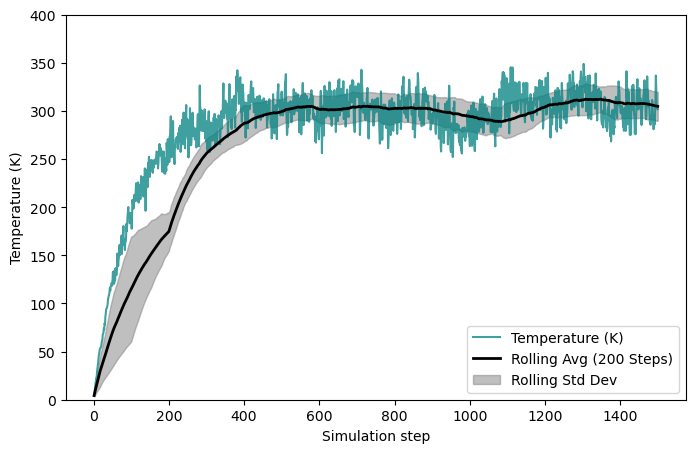

In [6]:
# Plot the temperature
plt.figure(figsize=(8, 5))
plt.plot(df[sim_step_label], df[temp_label], label=temp_label, color="teal", alpha=0.75)

# Plot rolling mean average
plt.plot(df[sim_step_label], df[rolling_avg_temperature], label=f'Rolling Avg ({steps} Steps)', color="black", linewidth=2)

# Plot rolling standard deviation as a shaded region
plt.fill_between(df[sim_step_label], 
                 df[rolling_avg_temperature] - df[rolling_stddev_temperature], 
                 df[rolling_avg_temperature] + df[rolling_stddev_temperature], 
                 color='gray', alpha=0.5, label="Rolling Std Dev")

# Formatting plot
plt.xlabel(sim_step_axis_label)
plt.ylabel(temp_label)
plt.ylim(0,400)
plt.legend()

# Show/save
# plt.show()
plt.savefig("17-alanine_equilibration_temperature-against-time.png")

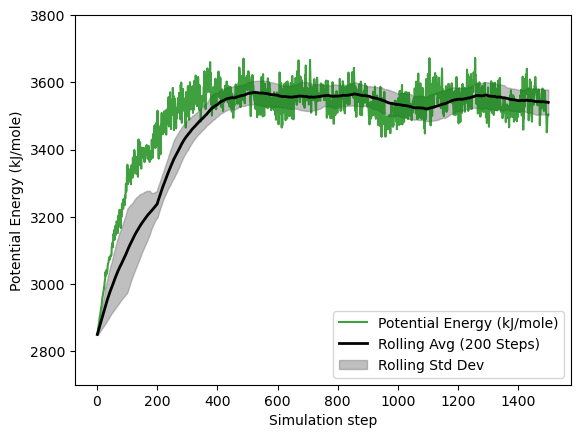

In [7]:
# Plot the potential energy
plt.plot(df[sim_step_label], df[pot_energy_label], label=pot_energy_label, color= 'green', alpha=0.75)

# Plot the rolling mean average
plt.plot(df[sim_step_label], df[rolling_avg_potential_energy], label=f'Rolling Avg ({steps} Steps)', color="black", linewidth=2)

# Plot rolling standard deviation as a shaded region
plt.fill_between(df[sim_step_label], 
                 df[rolling_avg_potential_energy] - df[rolling_stddev_potential_energy], 
                 df[rolling_avg_potential_energy] + df[rolling_stddev_potential_energy], 
                 color='gray', alpha=0.5, label="Rolling Std Dev")

# Formatting plot
plt.xlabel(sim_step_axis_label)
plt.ylabel(pot_energy_label)
plt.ylim(2700, 3800)
plt.legend()

# Show/save
# plt.show()
plt.savefig("17-alanine_equilibration_potential-energy-against-time.png")

## Step 3: Final check

In [ ]:
# Store file names
equilibrated_xml_file = "17-ala_equilibrated.xml"
final_check_dcd_path = "17-ala_equilibration_final_check.dcd"
final_check_statedata_path = "17-ala_equilibration_final_check.log"

In [ ]:
# Create OpenMM simulation
simulation = OpenMMSimulation.from_xml_path(equilibrated_xml_file)
simulation.load()

# Create reporters for recording the simulation
dcd_reporter = app.DCDReporter(final_check_dcd_path, 1)
statedata_reporter = app.StateDataReporter(final_check_statedata_path, 1, 
                                           temperature=True, step=True,
                                           time=True, potentialEnergy=True, kineticEnergy=True)

# Attach reporters
simulation.simulation.reporters.append(dcd_reporter)
simulation.simulation.reporters.append(statedata_reporter)

In [ ]:
# Set parameters
total_time_in_ps = 1500
time_step_interval = 0.002 # in ps
desired_interval_in_ps = 100

total_num_steps = total_time_in_ps/time_step_interval
print(f"Running for {total_num_steps} steps")

# Run the dynamics
cumulative_total_time_ps = 0

for n in range(int(total_time_in_ps/desired_interval_in_ps)):
    
    simulation.simulation.step(desired_interval_in_ps)
    cumulative_total_time_ps += desired_interval_in_ps
    print(f"{cumulative_total_time_ps} ps run.")

    # Save the simulation with the serialized State
    file_name =  f"17-ala_equilibration_final_check_{cumulative_total_time_ps}_ps.xml"
    with open(file_name, 'w') as outfile:
        outfile.write(serializer.serialize_simulation(simulation.simulation, save_state=True))


In [ ]:
# Close the reporters
dcd_reporter.__del__()
statedata_reporter.__del__()

## Step 3.5: Analysis

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
# Define data labels
pot_energy_label = "Potential Energy (kJ/mole)"
temp_label = "Temperature (K)"
sim_step_label = "Step #"
sim_step_axis_label = "Simulation step"

# Store file names
equilibrated_xml_file = "17-ala_equilibrated.xml"
final_check_dcd_path = "17-ala_equilibration_final_check.dcd"
final_check_statedata_path = "17-ala_equilibration_final_check.log"

rolling_avg_temperature ="Rolling average temperature"
rolling_stddev_temperature = "Rolling std dev temperature"
rolling_avg_potential_energy ="Rolling average potential energy"
rolling_stddev_potential_energy = "Rolling std dev potential energy"

# Load the log file into a Pandas DataFrame
df = pd.read_csv(final_check_statedata_path, sep=",")

# Format the column headings and print
sim_step_label = "Step #"
df = df.rename(columns={'#"Step"': sim_step_label})

# Compute rolling averages
steps = 200
df[rolling_avg_temperature] = df[temp_label].rolling(window=steps, min_periods=1).mean()
df[rolling_stddev_temperature] = df[temp_label].rolling(window=100, min_periods=1).std()

df[rolling_avg_potential_energy] = df[pot_energy_label].rolling(window=steps, min_periods=1).mean()
df[rolling_stddev_potential_energy] = df[pot_energy_label].rolling(window=100, min_periods=1).std()

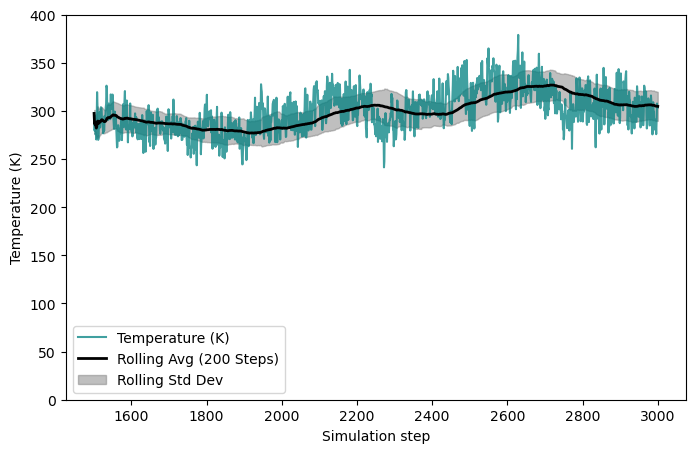

In [12]:
# Plot the temperature
plt.figure(figsize=(8, 5))
plt.plot(df[sim_step_label], df[temp_label], label=temp_label, color="teal", alpha=0.75)

# Plot rolling mean average
plt.plot(df[sim_step_label], df[rolling_avg_temperature], label=f'Rolling Avg ({steps} Steps)', color="black", linewidth=2)

# Plot rolling standard deviation as a shaded region
plt.fill_between(df[sim_step_label], 
                 df[rolling_avg_temperature] - df[rolling_stddev_temperature], 
                 df[rolling_avg_temperature] + df[rolling_stddev_temperature], 
                 color='gray', alpha=0.5, label="Rolling Std Dev")

# Formatting plot
plt.xlabel(sim_step_axis_label)
plt.ylabel(temp_label)
plt.ylim(0,400)
plt.legend()

# Show/save
# plt.show()
plt.savefig("17-alanine_final-check-of-equilibration_temperature-against-time.png")

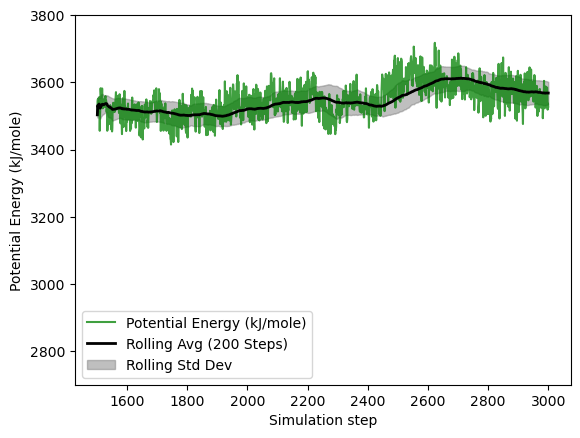

In [13]:
# Plot the potential energy
plt.plot(df[sim_step_label], df[pot_energy_label], label=pot_energy_label, color= 'green', alpha=0.75)

# Plot the rolling mean average
plt.plot(df[sim_step_label], df[rolling_avg_potential_energy], label=f'Rolling Avg ({steps} Steps)', color="black", linewidth=2)

# Plot rolling standard deviation as a shaded region
plt.fill_between(df[sim_step_label], 
                 df[rolling_avg_potential_energy] - df[rolling_stddev_potential_energy], 
                 df[rolling_avg_potential_energy] + df[rolling_stddev_potential_energy], 
                 color='gray', alpha=0.5, label="Rolling Std Dev")

# Formatting plot
plt.xlabel(sim_step_axis_label)
plt.ylabel(pot_energy_label)
plt.ylim(2700, 3800)
plt.legend()

# Show/save
# plt.show()
plt.savefig("17-alanine_final-check-of-equilibration_potential-energy-against-time.png")